## Happy-Sad Image Classifier

This project is a simple deep learning-based image classifier that distinguishes between happy and sad expressions. The model is built using TensorFlow and Keras and trained on a labeled dataset of images.

In [1]:
# Import required libraries
import tensorflow as tf 
import os
import numpy as np

In [2]:
# Check TensorFlow version
print("Tensorflow Version:", tf.__version__)

Tensorflow Version: 2.16.2


In [3]:
# List available hardware (CPU/GPU)
#List number of CPUs
cpus = tf.config.experimental.list_physical_devices('CPU')
cpus

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [4]:
# List available hardware (CPU/GPU)
# List number of GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# List available hardware (CPU/GPU)
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

Remove dodgy images

In [6]:
import cv2
from PIL import Image
from matplotlib import pyplot as plt

In [7]:
data_dir = 'data'

In [8]:
os.listdir(data_dir)

['happy', '.DS_Store', 'sad']

In [9]:
os.listdir(os.path.join(data_dir,"happy"))[0:5]

['images26.jpg',
 'images32.jpg',
 'e162ccda8ce0f197f8863f327add9233.jpg',
 '05-12-21-happy-people.jpg',
 'image22.jpeg']

In [10]:
image_exts = ['jpeg','jpg','bmp','png']

In [11]:
image_exts[2]

'bmp'

In [12]:
# get the file extension
def get_image_format(file_path):
    with Image.open(file_path) as img:
        return img.format


In [13]:
sample_img = cv2.imread(os.path.join('data','happy','1-2.jpg'))

In [14]:
sample_img.shape

(350, 590, 3)

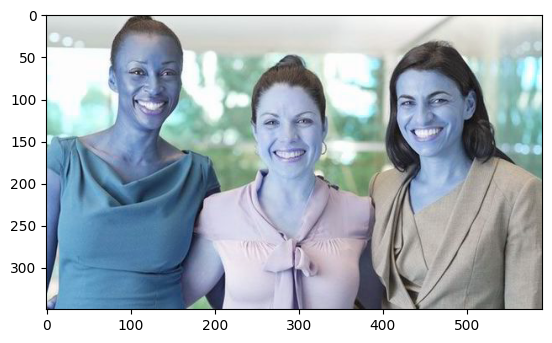

In [15]:
plt.imshow(sample_img)
plt.show()

The color is not as expected because of how Open CV hadles color channels

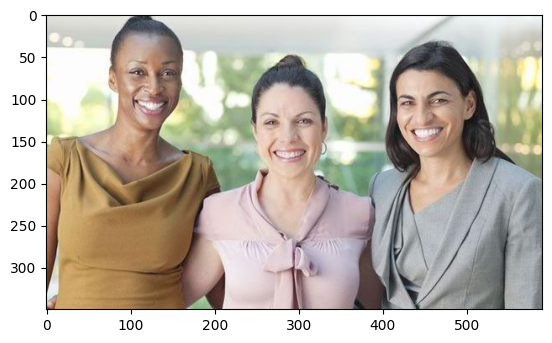

In [16]:
# To fix color
plt.imshow(cv2.cvtColor(sample_img,cv2.COLOR_BGR2RGB))
plt.show()

In [17]:
my_path = os.path.join(data_dir, 'happy')
my_image = os.path.join(my_path,os.listdir(my_path)[2])
my_image

'data/happy/e162ccda8ce0f197f8863f327add9233.jpg'

In [18]:
get_image_format(my_image)

'JPEG'

In [19]:
# clean out files
for image_class in os.listdir(data_dir):
    class_path = os.path.join(data_dir,image_class)
    if not os.path.isdir(class_path):
        continue
    for image in os.listdir(class_path):
        image_path = os.path.join(class_path,image)
        try:
            img = cv2.imread(image_path)
            tip = get_image_format(image_path)
            if tip.lower() not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

Load Data

In [20]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


2025-02-25 22:08:41.490032: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-02-25 22:08:41.490072: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-02-25 22:08:41.490081: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-02-25 22:08:41.490105: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-25 22:08:41.490121: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [21]:
data_iterator = data.as_numpy_iterator()

In [22]:
# Get a batch from the iterator
batch = data_iterator.next()

In [23]:
len(batch)

2

In [24]:
# images represented as arrays
batch[0].shape

(32, 256, 256, 3)

In [25]:
#Class 1 is happy people, class 0 is sad people
batch[1]

array([0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0], dtype=int32)

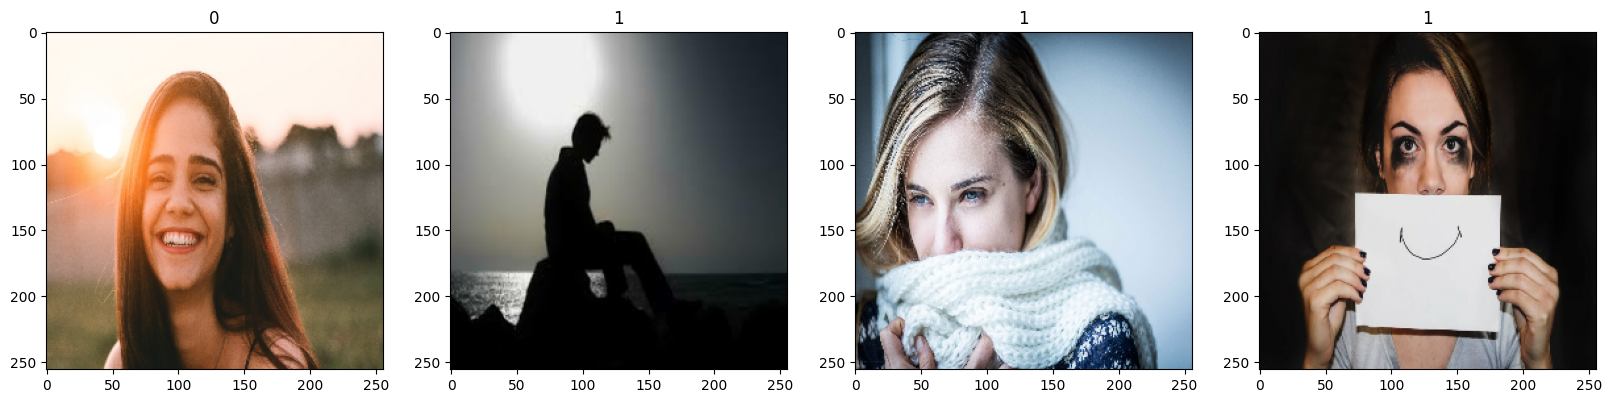

In [26]:
fig, ax = plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Preprocessing

In [27]:
data = data.map(lambda x,y:(x/255,y))

In [28]:
scaled_iterator = data.as_numpy_iterator()

In [29]:
batch = scaled_iterator.next()

In [30]:
batch[0].max()

1.0

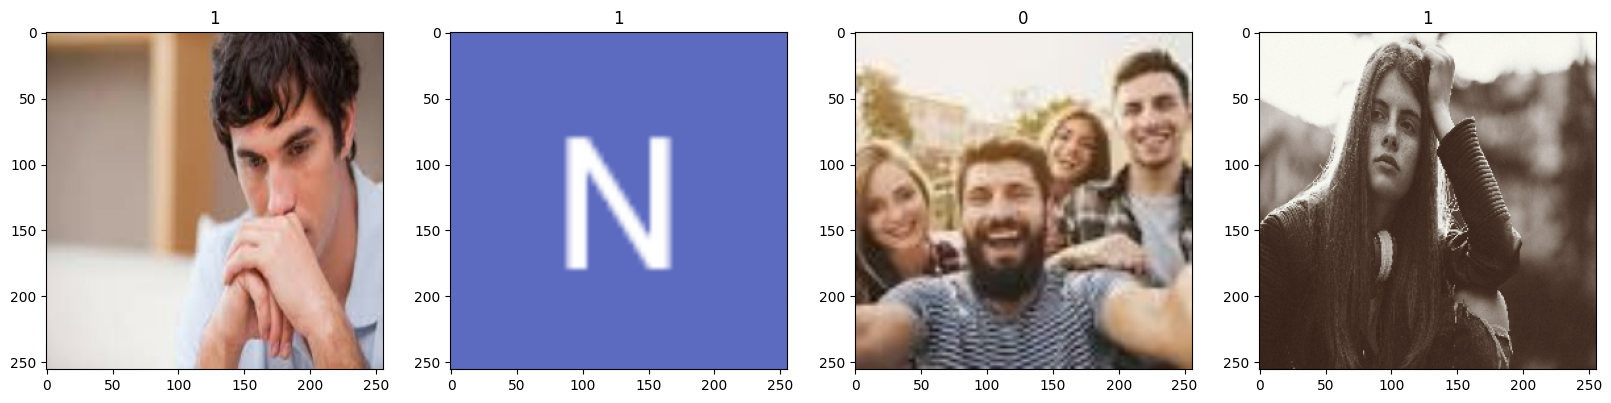

In [31]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

2.2 Split Data

In [32]:
len(data)

10

In [33]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [34]:
train_size, val_size , test_size

(7, 2, 1)

In [35]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [36]:
len(train)

7

Build Deep Learning Model

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout

In [38]:
model = Sequential()

In [39]:
model.add(Conv2D(16,(3,3),1,activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

/Users/freedmores/miniforge3/envs/tf_env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [40]:
# Compile the CNN model
model.compile('adam',loss=tf._losses.BinaryCrossentropy(),metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

Train

In [42]:
logdir = 'logs'

In [43]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [44]:
# Train the CNN model
hist = model.fit(train,epochs=20,validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/20


2025-02-25 22:10:29.843372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - accuracy: 0.5209 - loss: 0.7857 - val_accuracy: 0.6875 - val_loss: 0.6577
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.7187 - loss: 0.6533 - val_accuracy: 0.8438 - val_loss: 0.5830
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.7399 - loss: 0.5662 - val_accuracy: 0.7500 - val_loss: 0.4457
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - accuracy: 0.8387 - loss: 0.4299 - val_accuracy: 0.8750 - val_loss: 0.3627
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.8789 - loss: 0.3276 - val_accuracy: 0.9375 - val_loss: 0.2458
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.9397 - loss: 0.2181 - val_accuracy: 0.9219 - val_loss: 0.2632
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - accuracy: 0.9596 - loss: 0.1630 - val_accuracy: 0.9531 - val_loss: 0.1368
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.9619 - loss: 0.1322 - val_accuracy: 0.9531 - val_loss: 0.1174
Epo

In [45]:
hist.history

{'accuracy': [0.5446428656578064,
  0.7053571343421936,
  0.7366071343421936,
  0.8705357313156128,
  0.8794642686843872,
  0.9508928656578064,
  0.96875,
  0.9464285969734192,
  0.9866071343421936,
  0.9910714030265808,
  0.9910714030265808,
  0.9955357313156128,
  0.9910714030265808,
  0.9955357313156128,
  0.9955357313156128,
  0.9910714030265808,
  0.9955357313156128,
  1.0,
  0.9955357313156128,
  0.9955357313156128],
 'loss': [0.7559723258018494,
  0.6501898765563965,
  0.5475887060165405,
  0.38352274894714355,
  0.3295217454433441,
  0.21820294857025146,
  0.14370891451835632,
  0.14609193801879883,
  0.06698334962129593,
  0.05564010888338089,
  0.03508166968822479,
  0.026571836322546005,
  0.022294024005532265,
  0.02392379753291607,
  0.026512371376156807,
  0.018289247527718544,
  0.015035582706332207,
  0.006267184857279062,
  0.008644510991871357,
  0.017443012446165085],
 'val_accuracy': [0.6875,
  0.84375,
  0.75,
  0.875,
  0.9375,
  0.921875,
  0.953125,
  0.953125,


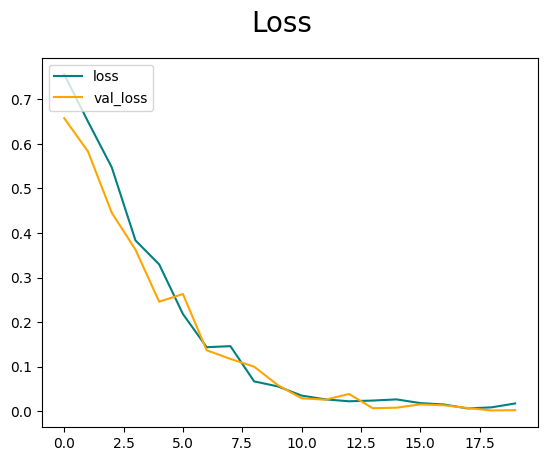

In [46]:
fig = plt.figure()
plt.plot(hist.history['loss'],color='teal',label='loss')
plt.plot(hist.history['val_loss'], color='orange',label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc='upper left')
plt.show()

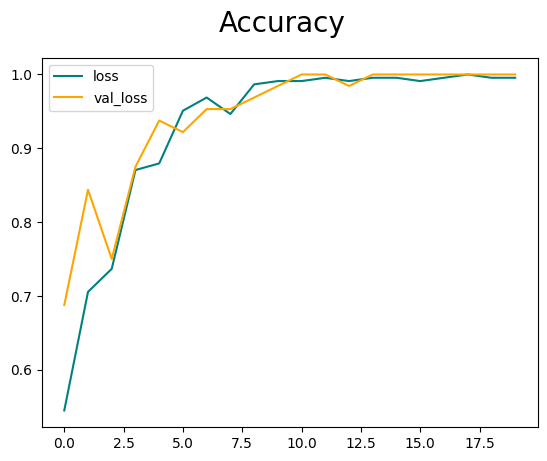

In [47]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='loss')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_loss')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

Evaluate Perfomance

In [48]:
from tensorflow.keras.metrics import Precision,Recall,BinaryAccuracy

In [49]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [50]:
# Make predictions on new images
for batch in test.as_numpy_iterator():
    X,y = batch
    yhat = model.predict(X)
    pre.update_state(y,yhat)
    re.update_state(y,yhat)
    acc.update_state(y,yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


2025-02-25 22:11:52.778001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [51]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy:1.0


Test on data outside the batch

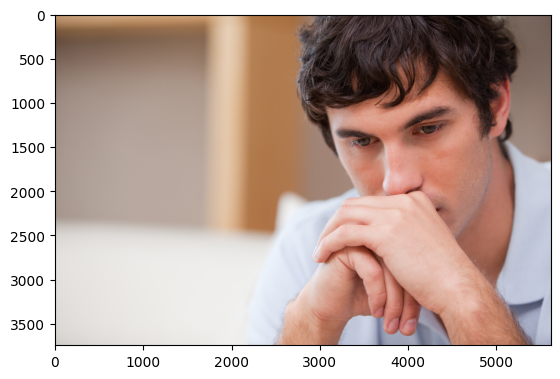

In [52]:
img_test = cv2.imread('8iAb9k4aT.jpg')
plt.imshow(cv2.cvtColor(img_test,cv2.COLOR_BGR2RGB))
plt.show()

In [53]:
resize = tf.image.resize(img_test,(256,256))

In [54]:
# Make predictions on new images
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


In [55]:
yhat

array([[0.994653]], dtype=float32)

In [56]:
if yhat>0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


Save the Model

In [57]:
from tensorflow.keras.models import load_model

In [58]:
model.save(os.path.join('models','happysadmodel.h5'))

In [59]:
new_model = load_model(os.path.join('models','happysadmodel.h5'))

In [60]:
# Make predictions on new images
yhat_new = new_model.predict(np.expand_dims(resize/255,0))
yhat_new

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


array([[0.994653]], dtype=float32)

In [61]:
if yhat_new > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad
